In [1]:
# venv
import torch
import datetime as dt
print(torch.__version__)

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found. Using CPU.")

2.0.1+cu117
GPU is available.


In [2]:
import os, subprocess, glob, srt
from shutil import rmtree
import cv2
import demoTalkNetMod
import logging
import os
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import srt
import whisper

from stable_whisper import modify_model
from pyannote.core import Segment, Annotation
from pyannote.core import notebook
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os
load_dotenv()
import torch
from pyannote.audio import Pipeline
os.environ["CUDA_VISIBLE_DEVICES"]="1"

logger = logging.getLogger("transcribe")

pretrained_pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization-3.0",
                                               use_auth_token=os.getenv('HUGGINGFACE_TOKEN'))
pretrained_pipeline.to(torch.device("cuda"))
# sys.path.append(os.path.abspath("TalkNet-ASD/"))

2024-01-18 00:52:41.920870977 [W:onnxruntime:, session_state.cc:1162 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-01-18 00:52:41.920896758 [W:onnxruntime:, session_state.cc:1164 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


In [3]:
def create_annotation_plot(speaker_timelines):
    custom_diarization = Annotation()

    for speaker_key in speaker_timelines.keys():
        for timeline in speaker_timelines[speaker_key]:
            custom_diarization[Segment(timeline[0], timeline[1])] = speaker_key

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 2))

    # Plot the custom diarization result
    notebook.plot_annotation(custom_diarization, ax, legend=True)

    # Customize the plot (if needed)
    ax.set_xlabel("Time")
    ax.set_yticks([])  # To hide the y-axis

    # Save the figure
    #     fig.savefig('custom_diarization_plot.png', bbox_inches='tight')

    # Show the figure (optional)
    plt.show()


def get_whisper_model(model_name="base"):
    # initialize model
    logging.info(f"Initializing openai's '{model_name} 'model")
    if model_name in [
        "tiny.en",
        "tiny",
        "base.en",
        "base",
        "small.en",
        "small",
        "medium.en",
        "medium",
        "large",
    ]:
        try:
            model = whisper.load_model(model_name)
            # Using the stable whisper to modifiy the model for better timestamps accuracy
            modify_model(model)
            logging.info("Model was successfully initialized")
        except:
            logging.error("Unable to initialize openai model")
            return None
    else:
        logging.error(
            "Model  not found; available models = ['tiny.en', 'tiny', 'base.en', 'base', 'small.en', 'small', 'medium.en', 'medium', 'large']"
        )
        return None

    return model


def get_whisper_result(file_path, model):
    logging.info(f"Generating transcription for file - {file_path}")

    decode_options = dict(language="en")
    transcribe_options = dict(task="transcribe", **decode_options)
    output = model.transcribe(file_path, **transcribe_options)
    output = model.align(file_path, output, language="en")
    return output


def generate_whisper_transcription(file_name, file_path, output):
    logging.info(f"Organizing transcription for file - {file_path}")

    transcriptions = {}

    for num, s in enumerate(output.segments):
        transcriptions[num] = []
        for word in s.words:
            transcriptions[num].append(
                {
                    "text": s.text.strip(),
                    "segment_start": s.start,
                    "segment_end": s.end,
                    "word": word.word.strip(),
                    "word_start": word.start,
                    "word_end": word.end,
                }
            )

    rows = []

    for key, words in transcriptions.items():
        for word in words:
            row = {
                "file_name": file_name,
                "segment_id": key,
                "segment_text": word["text"],
                "segment_start": word["segment_start"],
                "segment_end": word["segment_end"],
                "word": word["word"],
                "word_start": word["word_start"],
                "word_end": word["word_end"],
            }
            rows.append(row)

    df = pd.DataFrame(rows)

    return df


def find_overlap(intervals1, intervals2):
    overlap = 0
    total_duration1 = 0
    total_duration2 = 0

    # Calculate the total duration of intervals in intervals1
    for start, end in intervals1:
        total_duration1 += end - start

    # Calculate the total duration of intervals in intervals2 and find the overlap
    for start, end in intervals2:
        total_duration2 += end - start
        for s1, e1 in intervals1:
            common_start = max(s1, start)
            common_end = min(e1, end)
            if common_start < common_end:
                overlap += common_end - common_start

    # Calculate the percentage of overlap with respect to intervals1
    percentage_overlap1 = (overlap / total_duration1) * 100

    # Calculate the percentage of overlap with respect to intervals2
    percentage_overlap2 = (overlap / total_duration2) * 100

    return percentage_overlap1, percentage_overlap2


def get_video_to_audio_mapping(video_output, audio_output):
    video_audio_mapping = {}
    for audio_speaker in audio_output.keys():
        for video_speaker in video_output.keys():
            video_overlap, _ = find_overlap(video_output[video_speaker], audio_output[audio_speaker])
            if video_overlap > 80:
                video_audio_mapping[audio_speaker] = video_speaker
                break
    return video_audio_mapping


def get_segment_to_speaker_mapping(segment_start, segment_end, speaker_mapping, audio_output):
    final_speaker = None
    max_overlap = 0

    for audio_speaker in audio_output.keys():
        segment_overlap, _ = find_overlap([(segment_start, segment_end)], audio_output[audio_speaker])
        if segment_overlap > max_overlap:
            final_speaker = audio_speaker
            max_overlap = segment_overlap

    if final_speaker is None:
        return "Unknown", max_overlap
    else:
        if final_speaker in speaker_mapping.keys():
            return speaker_mapping[final_speaker], max_overlap
        else:
            return final_speaker, max_overlap


def get_word_to_speaker_mapping(word_start, word_end, diarization_output):
    for audio_speaker, speaker_timeline in diarization_output.items():
        segment_overlap, _ = find_overlap([(word_start, word_end)], speaker_timeline)
        if segment_overlap > 0.5:
            return audio_speaker

    return "Unknown"


def get_segments_and_speaker(df, diarization_output, video_name):
    temp_df = df[df["video_name"] == video_name].copy()
    temp_df["word_end"] = temp_df.apply(
        lambda row: (row["word_end"] + 0.1) if row["word_end"] == row["word_start"] else row["word_end"], axis=1
    )

    temp_df["assigned_speaker"] = temp_df.apply(
        lambda row: get_word_to_speaker_mapping(row["word_start"], row["word_end"], diarization_output), axis=1
    )

    # temp_df = (
    #     temp_df[["segment_id", "speaker", "word", "word_start", "word_end"]]
    #     .groupby(["segment_id", "speaker"], as_index=False)
    #     .agg({"word": " ".join, "word_start": min, "word_end": max})
    # )

    # temp_df["segment_id"] = temp_df.index + 1

    # temp_df["video_name"] = video_name

    return temp_df

def match_output(output_df):
    
    video_list = output_df["video_name"].unique()
    assigned_speaker_match = {}
    
    for video_name in video_list:
        
        temp_df = output_df[output_df["video_name"] == video_name]
    
        assigned_speaker_list = temp_df["assigned_speaker"].unique()
        video_speaker_match = {}
    
        for assigned_speaker in assigned_speaker_list:
            video_speaker_match[assigned_speaker] = temp_df[temp_df["assigned_speaker"] == assigned_speaker]["speaker"].value_counts().idxmax()
        
        assigned_speaker_match[video_name] = video_speaker_match
    
    output_df["matched_speaker"] = output_df.apply(lambda row: assigned_speaker_match[row["video_name"]][row["assigned_speaker"]], axis=1)
    
    output_df["matched_result"] = output_df.apply(lambda row: row["speaker"] == row["matched_speaker"], axis=1)
    
    return output_df
    
def compute_performance(output_df):
    
    output_df = output_df.groupby(by=["video_name", "matched_result"]).count()[["segment_id"]].reset_index()
    output_df.rename(columns={"segment_id": "count"}, inplace=True)
    
    df_pivot = output_df.pivot(index='video_name', columns='matched_result', values='count').reset_index()

    # Calculate accuracy
    df_pivot['accuracy'] = (df_pivot[True] / (df_pivot[True] + df_pivot[False])) * 100

    # Rename columns
    df_pivot.columns.name = None
    df_pivot = df_pivot.rename(columns={True: 'true_count', False: 'false_count'})
    
    return df_pivot

def create_srt(df, video_name, video_dir):
    temp_df = df[df["video_name"] == video_name].copy()

    temp_df.reset_index(drop=True, inplace=True)

    temp_df = (
        temp_df[["segment_id", "matched_speaker", "word", "word_start", "word_end"]]
        .groupby(["segment_id", "matched_speaker"], as_index=False)
        .agg({"word": " ".join, "word_start": min, "word_end": max})
    )

    temp_df["segment_id"] = temp_df.index + 1

    srt_list = temp_df.apply(
        lambda row: srt.Subtitle(
            index=row["segment_id"],
            start=timedelta(seconds=row["word_start"] if row["word_start"] < 0.1 else row["word_start"] - 0.1),
            end=timedelta(seconds=row["word_end"] + 0.1),
            content=f"{row['matched_speaker']}: {row['word']}",
        ),
        axis=1,
    ).to_list()

    srt_string = srt.compose(srt_list)
    with open(
        os.path.join(
            video_dir,
            os.path.splitext(video_name)[0] + "_predicted.srt",
        ),
        "w",
    ) as f:
        f.write(srt_string)

In [4]:
class Args:
    def __init__(self, args_dict):
        self.__dict__.update(args_dict)

args_dict = {
    "videoFolder":"Dataset/Temp",
    "outputFolder":"output",
    "pretrainModel":"pretrain_TalkSet.model",
    "nDataLoaderThread":10,
    "facedetScale":0.25,
    "minTrack":10,
    "numFailedDet":10,
    "minFaceSize":1,
    "cropScale":0.40,
    "start":0,
    "duration":0,
    "evalCol":False,
    "colSavePath":"/data08/col",
}

args = Args(args_dict)

if os.path.isfile(args.pretrainModel) == False:  # Download the pretrained model
    Link = "1AbN9fCf9IexMxEKXLQY2KYBlb-IhSEea"
    cmd = "gdown --id %s -O %s" % (Link, args.pretrainModel)
    subprocess.call(cmd, shell=True, stdout=None)


model_name_openai = "medium.en"
model = get_whisper_model(model_name_openai)

args.videoFiles = [
    os.path.splitext(f)[0]
    for f in os.listdir(args.videoFolder)
    if os.path.isfile(os.path.join(args.videoFolder, f)) and os.path.splitext(os.path.join(args.videoFolder, f))[1] in [".mp4"]
]
args.videoFiles

['StarTalk_CMBR_92_152',
 'NDT_India_19_88',
 'MagnusCarlson_542_599',
 'StarTalk_FlyingVehicles_300_340',
 'StarTalk_Sleep_748_796']

In [5]:
args.videoFiles = ['NDT_India_19_88']
args.videoFiles

['NDT_India_19_88']

In [6]:
final_video_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
    args.savePath = os.path.join(args.outputFolder, video_file)
    args.audioFilePath = os.path.join(args.savePath, "pyavi", "audio.wav")
    video = cv2.VideoCapture(args.videoPath)
    args.frameRate = video.get(cv2.CAP_PROP_FPS)
    video.release()
    print(args.frameRate)
    
    vidTracks, scores, args = demoTalkNetMod.preprocess(args)

    df, args = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)
    print(args.frameRate)

    # 001 - eps=0.4, min_samples = 4
    # PL - eps=0.5, min_samples = 200
    # Video3 - eps=0.5, min_samples = 100
    # Video2 - eps=0.5, min_samples = 100
    # Choose DBSCAN parameters
#     eps = 0.5
#     min_samples = 100

#     # Apply DBSCAN clustering
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     clusters = dbscan.fit_predict(df["Encoding"].to_list())
#     unique, counts = np.unique(clusters, return_counts=True)
#     print(np.asarray((unique, counts)).T)

    optimal_cluster = -1
    max_silhouette = 0
    encoding_list = df["Encoding"].to_list()
    for num_clusters in range(2,6):   
        kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(encoding_list)

        silhouette_avg = silhouette_score(encoding_list, cluster_labels)
        if silhouette_avg > max_silhouette:
            max_silhouette = silhouette_avg
            optimal_cluster = num_clusters

    print(optimal_cluster)
    kmeans = KMeans(n_clusters=optimal_cluster, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(encoding_list)

    df["Clusters"] = cluster_labels

    video_output = demoTalkNetMod.get_final_tracks(df, args)

    final_video_output[video_file] = video_output
final_video_output

NDT_India_19_88
29.97002997002997


2024-01-18 00:53:10 Extract the video and save in output/NDT_India_19_88/pyavi/video.avi 
2024-01-18 00:53:10 Extract the audio and save in output/NDT_India_19_88/pyavi/audio.wav 
2024-01-18 00:53:19 Extract the frames and save in output/NDT_India_19_88/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/NDT_India_19_88/pyavi/video.avi - scenes detected 5
2024-01-18 00:53:27 Scene detection and save in output/NDT_India_19_88/pywork 
2024-01-18 00:55:18 Face detection and save in output/NDT_India_19_88/pywork 
2024-01-18 00:55:18 Face track and detected 36 tracks 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████

01-18 00:56:53 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.83it/s]
2024-01-18 00:57:06 Scores extracted and saved in output/NDT_India_19_88/pywork 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [06:10<00:00,  3.22faces/s]
2024-01-18 01:03:17 Face encoding generation completed

25.033300515434068
5


{'NDT_India_19_88': {'SPEAKER_04': [(6.47, 6.95)],
  'SPEAKER_02': [(3.24, 6.43), (6.99, 15.98)],
  'SPEAKER_00': [(16.42, 24.53)],
  'SPEAKER_01': [(35.47, 35.95),
   (42.02, 58.96),
   (59.4, 63.24),
   (68.47, 68.95)],
  'SPEAKER_03': [(37.11, 41.11)]}}

In [5]:
# # Partial Copy
# df_list = []
# for video_file in args.videoFiles:
#     print(video_file)
#     args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
#     args.savePath = os.path.join(args.outputFolder, video_file)
#     args.audioFilePath = os.path.join(args.savePath, "pyavi", "audio.wav")
#     video = cv2.VideoCapture(args.videoPath)
#     args.frameRate = video.get(cv2.CAP_PROP_FPS)
#     video.release()
#     print(args.frameRate)
    
#     vidTracks, scores, args = demoTalkNetMod.preprocess(args)

#     df = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)
    
#     df["video_name"] = video_file

#     df_list.append(df)
# final_df = pd.concat(df_list)
# final_df.to_pickle("CustomUtils/Testing/del_later.pkl")

StarTalk_CMBR_92_152
23.976023976023978


2024-01-15 17:29:36 Extract the video and save in output/StarTalk_CMBR_92_152/pyavi/video.avi 
2024-01-15 17:29:37 Extract the audio and save in output/StarTalk_CMBR_92_152/pyavi/audio.wav 
2024-01-15 17:29:57 Extract the frames and save in output/StarTalk_CMBR_92_152/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_CMBR_92_152/pyavi/video.avi - scenes detected 6
2024-01-15 17:30:12 Scene detection and save in output/StarTalk_CMBR_92_152/pywork 
2024-01-15 17:31:43 Face detection and save in output/StarTalk_CMBR_92_152/pywork 
2024-01-15 17:31:43 Face track and detected 15 tracks 
100%|█████████████████████████████████████████████████████████████████████████████████████

01-15 17:32:30 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.52it/s]
2024-01-15 17:32:37 Scores extracted and saved in output/StarTalk_CMBR_92_152/pywork 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1240/1240 [06:25<00:00,  3.22tracks/s]
2024-01-15 17:39:02 Face encoding generation completed

NDT_India_19_88
29.97002997002997


2024-01-15 17:39:12 Extract the video and save in output/NDT_India_19_88/pyavi/video.avi 
2024-01-15 17:39:12 Extract the audio and save in output/NDT_India_19_88/pyavi/audio.wav 
2024-01-15 17:39:21 Extract the frames and save in output/NDT_India_19_88/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/NDT_India_19_88/pyavi/video.avi - scenes detected 5
2024-01-15 17:39:29 Scene detection and save in output/NDT_India_19_88/pywork 
2024-01-15 17:41:23 Face detection and save in output/NDT_India_19_88/pywork 
2024-01-15 17:41:23 Face track and detected 36 tracks 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████

01-15 17:43:00 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:12<00:00,  2.82it/s]
2024-01-15 17:43:13 Scores extracted and saved in output/NDT_India_19_88/pywork 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1191/1191 [06:10<00:00,  3.22tracks/s]
2024-01-15 17:49:23 Face encoding generation completed

MagnusCarlson_542_599
29.97002997002997


2024-01-15 17:49:31 Extract the video and save in output/MagnusCarlson_542_599/pyavi/video.avi 
2024-01-15 17:49:31 Extract the audio and save in output/MagnusCarlson_542_599/pyavi/audio.wav 
2024-01-15 17:49:39 Extract the frames and save in output/MagnusCarlson_542_599/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/MagnusCarlson_542_599/pyavi/video.avi - scenes detected 23
2024-01-15 17:49:45 Scene detection and save in output/MagnusCarlson_542_599/pywork 
2024-01-15 17:51:02 Face detection and save in output/MagnusCarlson_542_599/pywork 
2024-01-15 17:51:02 Face track and detected 37 tracks 
100%|██████████████████████████████████████████████████████████████████████████████

01-15 17:52:07 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:08<00:00,  4.17it/s]
2024-01-15 17:52:16 Scores extracted and saved in output/MagnusCarlson_542_599/pywork 
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1193/1193 [06:37<00:00,  3.00tracks/s]
2024-01-15 17:58:53 Face encoding generation completed

StarTalk_FlyingVehicles_300_340
24.0


2024-01-15 17:58:56 Extract the video and save in output/StarTalk_FlyingVehicles_300_340/pyavi/video.avi 
2024-01-15 17:58:56 Extract the audio and save in output/StarTalk_FlyingVehicles_300_340/pyavi/audio.wav 
2024-01-15 17:58:58 Extract the frames and save in output/StarTalk_FlyingVehicles_300_340/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 854 x 480
INFO:pyscenedetect:Downscale factor set to 3, effective resolution: 284 x 160
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_FlyingVehicles_300_340/pyavi/video.avi - scenes detected 7
2024-01-15 17:59:01 Scene detection and save in output/StarTalk_FlyingVehicles_300_340/pywork 
2024-01-15 17:59:28 Face detection and save in output/StarTalk_FlyingVehicles_300_340/pywork 
2024-01-15 17:59:28 Face track and detected 15 tracks 
100%|█████████████████████

01-15 17:59:52 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  2.06it/s]
2024-01-15 18:00:00 Scores extracted and saved in output/StarTalk_FlyingVehicles_300_340/pywork 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 682/682 [05:05<00:00,  2.23tracks/s]
2024-01-15 18:05:05 Face encoding generation completed

StarTalk_Sleep_748_796
23.976023976023978


2024-01-15 18:05:24 Extract the video and save in output/StarTalk_Sleep_748_796/pyavi/video.avi 
2024-01-15 18:05:24 Extract the audio and save in output/StarTalk_Sleep_748_796/pyavi/audio.wav 
2024-01-15 18:05:41 Extract the frames and save in output/StarTalk_Sleep_748_796/pyframes 
ERROR:pyscenedetect:VideoManager is deprecated and will be removed.
INFO:pyscenedetect:Loaded 1 video, framerate: 25.000 FPS, resolution: 1920 x 1080
INFO:pyscenedetect:Downscale factor set to 7, effective resolution: 274 x 154
INFO:pyscenedetect:Detecting scenes...
ERROR:pyscenedetect:`base_timecode` argument is deprecated and has no effect.
output/StarTalk_Sleep_748_796/pyavi/video.avi - scenes detected 9
2024-01-15 18:05:57 Scene detection and save in output/StarTalk_Sleep_748_796/pywork 
2024-01-15 18:08:34 Face detection and save in output/StarTalk_Sleep_748_796/pywork 
2024-01-15 18:08:34 Face track and detected 14 tracks 
100%|█████████████████████████████████████████████████████████████████████████

01-15 18:09:28 Model para number = 15.01


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:09<00:00,  1.43it/s]
2024-01-15 18:09:38 Scores extracted and saved in output/StarTalk_Sleep_748_796/pywork 
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 795/795 [05:40<00:00,  2.33tracks/s]
2024-01-15 18:15:19 Face encoding generation completed

In [6]:
# df = demoTalkNetMod.get_track_face_encodings(vidTracks, scores, args)
# df.to_pickle(f"{args.savePath}/{args.videoName}.pkl")
# df = pd.read_pickle(f"{args.savePath}/{args.videoName}.pkl")

# # 001 - eps=0.4, min_samples = 4
# # PL - eps=0.5, min_samples = 200
# # Video3 - eps=0.5, min_samples = 100
# # Video2 - eps=0.5, min_samples = 100
# # Choose DBSCAN parameters
# eps = 0.5
# min_samples = 100

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps=eps, min_samples=min_samples)
# clusters = dbscan.fit_predict(df["Encoding"].to_list())
# unique, counts = np.unique(clusters, return_counts=True)
# print(np.asarray((unique, counts)).T)

# df["Clusters"] = clusters
# video_output = demoTalkNetMod.get_final_tracks(df, args)

# # video_output = {
# #     "SPEAKER_00": [(3.92, 5.64), (6.4, 6.56), (7.32, 12.68), (180.72, 183.44)],
# #     "SPEAKER_01": [
# #         (32.76, 45.48),
# #         (45.84, 81.76),
# #         (81.92, 82.24),
# #         (82.68, 87.64),
# #         (208.0, 238.12),
# #         (238.76, 243.04),
# #         (243.36, 249.96),
# #     ],
# #     "SPEAKER_02": [(87.72, 89.24), (90.24, 91.48), (91.6, 105.52), (107.24, 115.24), (157.0, 175.84), (177.56, 179.8)],
# # }
# video_output

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [03:22<00:00,  3.20tracks/s]
2024-01-03 23:45:16 Face encoding generation completed

In [10]:
final_audio_output = {}
for video_file in args.videoFiles:
    print(video_file)
    args.videoPath = glob.glob(os.path.join(args.videoFolder, video_file + ".*"))[0]
    args.savePath = os.path.join(args.outputFolder, video_file)
    args.audioPath = os.path.join(args.savePath, "pyavi", "audio.wav")

    diarization = pretrained_pipeline(args.audioPath)

    audio_output = {}
    for duration, _, speaker_key in diarization.itertracks(yield_label=True):
        if speaker_key in audio_output.keys():
            audio_output[speaker_key].append((round(duration.start, 2), round(duration.end, 2)))
        else:
            audio_output[speaker_key] = [(round(duration.start, 2), round(duration.end, 2))]

    final_audio_output[video_file] = audio_output
final_audio_output

NDT_India_19_88


{'NDT_India_19_88': {'SPEAKER_00': [(0.01, 0.18),
   (0.4, 16.39),
   (64.71, 64.95),
   (67.38, 67.82)],
  'SPEAKER_02': [(16.39, 23.73), (23.96, 28.82)],
  'SPEAKER_01': [(28.8, 41.3)],
  'SPEAKER_03': [(35.12, 36.44), (41.3, 69.16)]}}

In [6]:
final_audio_output

{'StarTalk_CMBR_92_152': {'SPEAKER_00': [(0.008488964346349746,
    3.7606112054329373),
   (6.460101867572156, 8.480475382003396),
   (8.66723259762309, 9.227504244482175),
   (10.229202037351444, 17.07130730050934),
   (17.258064516129032, 17.325976230899833),
   (17.64855687606112, 19.95755517826825),
   (20.500848896434633, 22.45331069609508),
   (22.606112054329373, 24.507640067911716),
   (24.813242784380307, 29.702886247877757),
   (31.383701188455007, 33.35314091680815),
   (33.62478777589134, 41.09507640067912),
   (41.48556876061121, 44.37181663837012),
   (45.23769100169779, 51.468590831918505),
   (51.48556876061121, 60.12733446519525)],
  'SPEAKER_01': [(2.01188455008489, 2.67402376910017),
   (3.8285229202037354, 6.137521222410866),
   (17.325976230899833, 17.64855687606112),
   (22.741935483870968, 22.96264855687606),
   (29.95755517826825, 33.62478777589134),
   (45.62818336162988, 48.03904923599321),
   (48.82003395585738, 50.43293718166384),
   (57.95415959252971, 58.

In [7]:
# Transcription
df = pd.read_excel("Dataset/Videos/Transcriptions_WithSpeakers.xlsx")
df["video_name"] = df["file_name"].apply(lambda x: os.path.splitext(x)[0])
df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name
0,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,I'm,0.00,0.18,Levy Rozman,MagnusCarlson_542_599
1,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,going,0.18,0.28,Levy Rozman,MagnusCarlson_542_599
2,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,to,0.28,0.36,Levy Rozman,MagnusCarlson_542_599
3,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,name,0.36,0.46,Levy Rozman,MagnusCarlson_542_599
4,MagnusCarlson_542_599.mp4,0,I'm going to name a sport.,0.00,0.94,a,0.46,0.66,Levy Rozman,MagnusCarlson_542_599
...,...,...,...,...,...,...,...,...,...,...
3326,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,isn't,45.60,46.22,Matthew Walker,StarTalk_Sleep_748_796
3327,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,it,46.26,46.38,Matthew Walker,StarTalk_Sleep_748_796
3328,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,a,46.38,46.52,Matthew Walker,StarTalk_Sleep_748_796
3329,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,strange,46.52,47.12,Matthew Walker,StarTalk_Sleep_748_796


In [46]:
final_df_list = []
for video_name, video_output in final_audio_output.items():
    final_df_list.append(get_segments_and_speaker(df, video_output, video_name))

final_df = pd.concat(final_df_list)

In [47]:
final_df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,assigned_speaker
682,StarTalk_CMBR_92_152.mp4,0,So.,0.00,0.32,So.,0.00,0.32,Chuck Nice,StarTalk_CMBR_92_152,SPEAKER_00
683,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,"Well,",0.50,0.74,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00
684,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,so,0.88,1.00,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00
685,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,here,1.00,1.36,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00
686,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,you,1.36,1.54,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00
...,...,...,...,...,...,...,...,...,...,...,...
3326,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,isn't,45.60,46.22,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02
3327,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,it,46.26,46.38,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02
3328,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,a,46.38,46.52,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02
3329,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,strange,46.52,47.12,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_01


In [48]:
final_df = match_output(final_df)
final_df

,file_name,segment_id,segment_text,segment_start,segment_end,word,word_start,word_end,speaker,video_name,assigned_speaker,matched_speaker,matched_result
682,StarTalk_CMBR_92_152.mp4,0,So.,0.00,0.32,So.,0.00,0.32,Chuck Nice,StarTalk_CMBR_92_152,SPEAKER_00,Neil deGrasse Tyson,False
683,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,"Well,",0.50,0.74,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00,Neil deGrasse Tyson,True
684,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,so,0.88,1.00,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00,Neil deGrasse Tyson,True
685,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,here,1.00,1.36,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00,Neil deGrasse Tyson,True
686,StarTalk_CMBR_92_152.mp4,1,"Well, so here you go.",0.50,1.74,you,1.36,1.54,Neil deGrasse Tyson,StarTalk_CMBR_92_152,SPEAKER_00,Neil deGrasse Tyson,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,isn't,45.60,46.22,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02,Gary O’Reilly,False
3327,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,it,46.26,46.38,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02,Gary O’Reilly,False
3328,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,a,46.38,46.52,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_02,Gary O’Reilly,False
3329,StarTalk_Sleep_748_796.mp4,19,So isn't it a strange thing?,45.46,47.54,strange,46.52,47.12,Matthew Walker,StarTalk_Sleep_748_796,SPEAKER_01,Neil deGrasse Tyson,False


In [49]:
temp = compute_performance(final_df)
temp

,video_name,false_count,true_count,accuracy
0,MagnusCarlson_542_599,31,127,80.379747
1,NDT_India_19_88,9,211,95.909091
2,StarTalk_CMBR_190_225,13,77,85.555556
3,StarTalk_CMBR_270_308,18,114,86.363636
4,StarTalk_CMBR_319_356,3,79,96.341463
5,StarTalk_CMBR_92_152,20,165,89.189189
6,StarTalk_FlyingVehicles_1001_1043,15,131,89.726027
7,StarTalk_FlyingVehicles_1980_2040,4,173,97.740113
8,StarTalk_FlyingVehicles_2446_2508,5,193,97.474747
9,StarTalk_FlyingVehicles_2670_2710,16,116,87.878788


In [53]:
for video_file in args.videoFiles:
    create_srt(final_df, video_file, args.outputFolder)

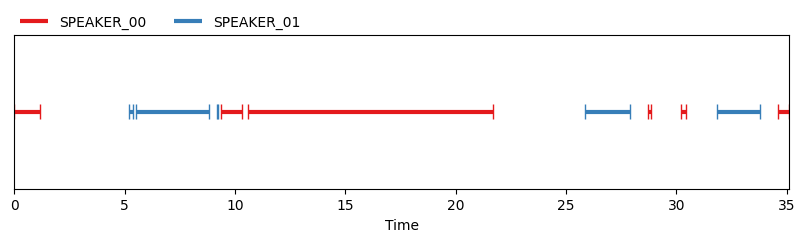

In [20]:
create_annotation_plot(video_output)

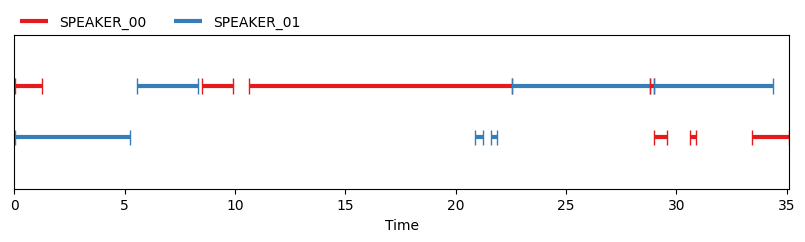

In [21]:
create_annotation_plot(audio_output)

In [22]:
video_audio_mapping = get_video_to_audio_mapping(video_output, audio_output)
video_audio_mapping

{'SPEAKER_00': 'SPEAKER_00', 'SPEAKER_01': 'SPEAKER_01'}

In [23]:
df = generate_openai_transcription(args.videoPath, model)

Transcribe: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 38.13/38.13 [00:03<00:00, 11.46sec/s]


In [24]:
df["segment_end"] = df.apply(
    lambda row: (row["segment_end"] + 0.1) if row["segment_start"] == row["segment_end"] else row["segment_end"], axis=1
)
df["word_end"] = df.apply(
    lambda row: (row["word_end"] + 0.1) if row["word_start"] == row["word_end"] else row["word_end"], axis=1
)
segment_df = df[["segment_id", "segment_text", "segment_start", "segment_end"]].drop_duplicates().reset_index(drop=True)
word_df = df[["segment_id", "word", "word_start", "word_end"]]
segment_df["speaker_output"] = segment_df.apply(
    lambda row: get_segment_to_speaker_mapping(
        row["segment_start"], row["segment_end"], video_audio_mapping, audio_output
    ),
    axis=1,
)
segment_df["speaker_key"] = segment_df["speaker_output"].apply(lambda x: x[0])
segment_df["speaker_confidence"] = segment_df["speaker_output"].apply(lambda x: x[1])

In [25]:
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{row['speaker_key']}: {row['segment_text']}"
    ),
    axis=1
)

In [26]:
# If name mapping known
name_mapping = {"SPEAKER_00": "Trump", "SPEAKER_01": "Piers"}
segment_df["Subtitles"] = segment_df.apply(
    lambda row: srt.Subtitle(
        index=row["segment_id"] + 1,
        start=timedelta(seconds=row["segment_start"] - 0.1 if row["segment_start"] > 0.1 else row["segment_start"]),
        end=timedelta(seconds=row["segment_end"] + 0.1),
        content=f"{name_mapping[row['speaker_key']]}: {row['segment_text']}"
    ),
    axis=1
)

In [27]:
srt_string = srt.compose(segment_df["Subtitles"].to_list())
with open(os.path.join(args.savePath, args.videoName + datetime.now().strftime("_%Y%m%d_%H%M%S") + ".srt"),
          "w",
         ) as f:
    f.write(srt_string)